### This exp works on the full dataset of size 1 only

In [1]:
import json
import itertools
import os
import statistics
import numpy as np

In [2]:
def ast_simplify(ast):
    current_children = []
    if "nodeType" in ast:
        if ast["nodeType"] == "SourceUnit":
            current_children.append("SourceUnit")
            for p in ast["nodes"]:
                current_children.append(ast_simplify(p))
        elif ast["nodeType"] == "PragmaDirective":
            pass
        elif ast["nodeType"] == "ContractDefinition":
            current_children.append("ContractDefinition")
            for p in ast["nodes"]:
                current_children.append(ast_simplify(p))
        elif ast["nodeType"] == "VariableDeclaration":
            current_children.append("VariableDeclaration")
            current_children.append(ast["name"])
        elif ast["nodeType"] == "ElementaryTypeName":
            pass
        elif ast["nodeType"] == "ArrayTypeName":
            pass
        elif ast["nodeType"] == "Block":
            current_children.append("Block")
            for p in ast["statements"]:
                current_children.append(ast_simplify(p))
        elif ast["nodeType"] == "Assignment":
            current_children.append("Assignment")
            current_children.append(ast_simplify(ast["leftHandSide"]))
            current_children.append(ast_simplify(ast["rightHandSide"]))
        elif ast["nodeType"] == "Identifier":
            current_children.append("Identifier")
            current_children.append(ast["name"])
        elif ast["nodeType"] == "BinaryOperation":
            current_children.append("BinaryOperation")
            current_children.append(ast["operator"])
            current_children.append(ast_simplify(ast["leftExpression"]))
            current_children.append(ast_simplify(ast["rightExpression"]))
        elif ast["nodeType"] == "MemberAccess":
            current_children.append("MemberAccess")
            current_children.append(ast_simplify(ast["expression"]))
            current_children.append(ast["memberName"])
        elif ast["nodeType"] == "TupleExpression":
            current_children.append("TupleExpression")
            for p in ast["components"]:
                current_children.append(ast_simplify(p))
        elif ast["nodeType"] == "IndexAccess":
            current_children.append("IndexAccess")
            current_children.append(ast_simplify(ast["baseExpression"]))
            current_children.append(ast_simplify(ast["indexExpression"]))
        elif ast["nodeType"] == "ExpressionStatement":
            current_children.append("ExpressionStatement")
            current_children.append(ast_simplify(ast["expression"]))
        elif ast["nodeType"] == "ForStatement":
            current_children.append("ForStatement")
            current_children.append(ast_simplify(ast["initializationExpression"]))
            current_children.append(ast_simplify(ast["loopExpression"]))
            current_children.append(ast_simplify(ast["condition"]))
            
            current_children.append(ast_simplify(ast["body"]))
        elif ast["nodeType"] == "VariableDeclarationStatement":
            current_children.append("VariableDeclarationStatement")
            for p in ast["declarations"]:
                current_children.append(ast_simplify(p))
            current_children.append(ast_simplify(ast["initialValue"]))
        elif ast["nodeType"] == "Literal":
            current_children.append("Literal")
        elif ast["nodeType"] == "FunctionDefinition":
            current_children.append("FunctionDefinition")
            current_children.append(ast_simplify(ast["body"]))
            # ignore "ParameterList" of "parameters"
        elif ast["nodeType"] == "UnaryOperation":
            current_children.append("UnaryOperation")
            current_children.append(ast["operator"])
            current_children.append(ast_simplify(ast["subExpression"]))
        elif ast["nodeType"] == "FunctionCall":
            current_children.append("FunctionCall")
            current_children.append(ast_simplify(ast["expression"]))
            for p in ast["arguments"]:
                current_children.append(ast_simplify(p))
        elif ast["nodeType"] == "ElementaryTypeNameExpression":
            current_children.append("ElementaryTypeNameExpression")
            current_children.append(ast["typeName"])
        else:
            pass
            # raise NotImplementedError("Unsupported Node Type: {}".format(ast["nodeType"]))
    else:
        pass
    
    return current_children

In [3]:
# simplified ast to reachability graph
# assume only one loop available and it's type is always ForStatement
def sast2rdict(sast):
    
    # dd is a node
    def locate_for_statement(dd):
        if isinstance(dd,list):
            if len(dd)==0:
                return None
            if isinstance(dd[0],str):
                if dd[0]=="ForStatement":
                    return dd
            ret = None
            for p in dd:
                ret = locate_for_statement(p)
                if ret is not None:
                    return ret
        else:
            return None
        
    # dd is a node
    def get_nearest_identifiers(dd):
        if isinstance(dd,list):
            if isinstance(dd[0],str):
                if dd[0]=="Identifier":
                    return [ dd[1] ] # assume parsed correctly
                elif dd[0]=="IndexAccess":
                    # only get the base identifier
                    return get_nearest_identifiers(dd[1])
                else:
                    ret = []
                    for p in dd[1:]:
                        tmpl = get_nearest_identifiers(p)
                        ret += tmpl
                    return ret
            else:
                raise Exception("Invalid type at pos 0: got {} but expected str".format(type(dd[0])))
        else:
            return []
        
    # dd is a node
    # (notice) in-place method
    def build_relations(dd, drels):
        if isinstance(dd,list):
            if isinstance(dd[0],str):
                if dd[0]=="Assignment":
                    # solid
                    # by default, Assignment type only has 2 children
                    tmp_to = get_nearest_identifiers(dd[1])
                    tmp_from = get_nearest_identifiers(dd[2])
                    assert len(tmp_to)>0
                    # (notice) if it's a=literal then the assertion won't hold
                    # so temporarily remove it: don't model literal assignment for now
                    # assert len(tmp_from)>0
                    for p in tmp_to:
                        for q in tmp_from:
                            drels.append( (p,"solid_in",q) )
                            drels.append( (q,"solid_out",p) )
                    build_relations(dd[1], drels) # leftHandSide
                    build_relations(dd[2], drels) # rightHandSide
                elif dd[0]=="IndexAccess":
                    # dotted
                    # by default, IndexAccess type only has 2 children
                    tmp_base = get_nearest_identifiers(dd[1])
                    tmp_index = get_nearest_identifiers(dd[2])
                    assert len(tmp_base)>0
                    assert len(tmp_index)>0
                    for p in tmp_base:
                        for q in tmp_index:
                            drels.append( (p,"dotted_in",q) )
                            drels.append( (q,"dotted_out",p) )
                    build_relations(dd[1], drels) # baseExpression
                    build_relations(dd[2], drels) # indexExpression
                else:
                    # no arrow, move to next level
                    for p in dd[1:]:
                        build_relations(p, drels)
            else:
                raise Exception("Invalid type at pos 0: got {} but expected str".format(type(dd[0])))
        else:
            return
        
    def get_variables_assigned(dd):
        if isinstance(dd,list):
            if isinstance(dd[0],str):
                if dd[0]=="Assignment":
                    ret = get_nearest_identifiers(dd[1]) + get_variables_assigned(dd[2])
                    return ret
                elif dd[0]=="FunctionCall":
                    # temporary fix to support `require`
                    if dd[1][1]=="require":
                        ret = []
                        for p in dd[2:]:
                            ret += get_nearest_identifiers(p)
                        return ret
                    else:
                        # do not support this
                        ret = []
                        for p in dd[1:]:
                            ret += get_variables_assigned(p)
                        return ret
                else:
                    ret = []
                    for p in dd[1:]:
                        ret += get_variables_assigned(p)
                    return ret
            else:
                raise Exception("Invalid type at pos 0: got {} but expected str".format(type(dd[0])))
        else:
            return []
        
    collected_relations = []
    loop_node = locate_for_statement(sast)
    
    # first find out all relations
    # ignore loop conditions
    # go to loop body
    build_relations(loop_node[4], collected_relations)
    rdict = {}
    # then find out loop variables
    # may have multiple loop variable declarations
    # display(loop_node)
    if loop_node[1][0]=="VariableDeclarationStatement":
        # patterns like: for (uint i=0; ...)
        for tmp_elem in loop_node[1][1:-1]:
            tmp_loop_var = tmp_elem[1]
            rdict[tmp_loop_var] = {"type":"loop_var", "dotted_in":[], "dotted_out":[], "solid_in":[], "solid_out":[]}
    elif loop_node[1][0]=="ExpressionStatement":
        # patterns like: for (i=0; ...)
        for tmp_elem in loop_node[1][1:]:
            tmp_loop_var = tmp_elem[1][1]
            rdict[tmp_loop_var] = {"type":"loop_var", "dotted_in":[], "dotted_out":[], "solid_in":[], "solid_out":[]}
    else:
        raise NotImplementedError("Unsupported nodeType in ForStatement: {}".format(loop_node[1][0]))
    # then find out variables being assigned
    tmp_ass_vars = get_variables_assigned(loop_node)
    for tmp_var in tmp_ass_vars:
        if tmp_var in rdict.keys():
            # loop_var overrides ass_var
            continue
        else:
            rdict[tmp_var] = {"type":"ass_var", "dotted_in":[], "dotted_out":[], "solid_in":[], "solid_out":[]}
    
    # then based on the relations, construct the rdict
    for p in collected_relations:
        if p[0] not in rdict.keys():
            rdict[p[0]] = {"type":"var", "dotted_in":[], "dotted_out":[], "solid_in":[], "solid_out":[]}
        if p[2] not in rdict.keys():
            rdict[p[2]] = {"type":"var", "dotted_in":[], "dotted_out":[], "solid_in":[], "solid_out":[]}
        rdict[p[0]][p[1]].append(p[2])
    
    
    return rdict

### Feature Generation for a Graph
(path related features)
- number of any path from one red to one purple (min, max)
- number of all-dotted path from one red to one purple (min, max)
- number of all-solid path from one red to one purple (min, max)
- number of mixed path from one red to one purple (min, max)

(degree related features)
- number of ins of a purple (min, max)
- number of outs of a purple (min, max)
- number of dotted-ins of a purple (min, max)
- number of dotted-outs of a purple (min, max)
- number of solid-ins of a purple (min, max)
- number of solid-outs of a purple (min, max)
- (...) of a red (min, max)

(special features)
- number of in-out of a purple to itself (min, max)
- max number of hops from a red to a purple (excluding red including purple) (min, max, average)

In [4]:
def getf_num_any_path_r2p(rdict, var_r, var_p):
    def traverse(cl):
        ret = 0
        for p in cl:
            if p==var_p:
                ret += 1
            else:
                ret += traverse(rdict[p]["dotted_out"])
                ret += traverse(rdict[p]["solid_out"])
        return ret
    
    return traverse(rdict[var_r]["dotted_out"]) + traverse(rdict[var_r]["solid_out"])

def getf_num_dotted_path_r2p(rdict, var_r, var_p):
    def traverse(cl):
        ret = 0
        for p in cl:
            if p==var_p:
                ret += 1
            else:
                ret += traverse(rdict[p]["dotted_out"])
        return ret
    
    return traverse(rdict[var_r]["dotted_out"])

def getf_num_solid_path_r2p(rdict, var_r, var_p):
    def traverse(cl):
        ret = 0
        for p in cl:
            if p==var_p:
                ret += 1
            else:
                ret += traverse(rdict[p]["solid_out"])
        return ret
    
    return traverse(rdict[var_r]["solid_out"])

def getf_num_mixed_path_r2p(rdict, var_r, var_p):
    num_any = getf_num_any_path_r2p(rdict, var_r, var_p)
    num_dotted = getf_num_dotted_path_r2p(rdict, var_r, var_p)
    num_solid = getf_num_solid_path_r2p(rdict, var_r, var_p)
    return num_any - num_dotted - num_solid

def getf_num_in_out_p(rdict, var_p):
    # technically a purple can't have dotted arrows to itself
    ret = 0
    for p in rdict[var_p]["solid_out"]:
        if p==var_p:
            ret += 1
    return ret

def getlist_num_hops_r2p(rdict, var_r, var_p):
    def traverse(cl, nh):
        ret = []
        for p in cl:
            if p==var_p:
                ret.append(nh+1)
            else:
                ret += traverse(rdict[p]["dotted_out"],nh+1)
                ret += traverse(rdict[p]["solid_out"],nh+1)
        return ret
    
    return traverse(rdict[var_r]["dotted_out"],0) + traverse(rdict[var_r]["solid_out"],0)

In [5]:
def build_features(rdict):
    # first find out red/purple list
    red_list = [dkey for dkey in rdict.keys() if rdict[dkey]["type"]=="loop_var"]
    purple_list = [dkey for dkey in rdict.keys() if rdict[dkey]["type"]=="ass_var"]
    rp_list = [(r,p) for r in red_list for p in purple_list]
    
    # build path related features
    # --> number of any path from one red to one purple (min, max)
    tmp_num_any_path_r2p = [getf_num_any_path_r2p(rdict,*q) for q in rp_list]
    # --> number of all-dotted path from one red to one purple (min, max)
    tmp_num_dotted_path_r2p = [getf_num_dotted_path_r2p(rdict,*q) for q in rp_list]
    # --> number of all-solid path from one red to one purple (min, max)
    tmp_num_solid_path_r2p = [getf_num_solid_path_r2p(rdict,*q) for q in rp_list]
    # -->number of mixed path from one red to one purple (min, max)
    tmp_num_mixed_path_r2p = [getf_num_mixed_path_r2p(rdict,*q) for q in rp_list]
    
    # build degree related features
    tmp_num_ins_p = [len(rdict[p]["dotted_in"])+len(rdict[p]["solid_in"]) for p in purple_list]
    tmp_num_outs_p = [len(rdict[p]["dotted_out"])+len(rdict[p]["solid_out"]) for p in purple_list]
    tmp_num_dotted_ins_p = [len(rdict[p]["dotted_in"]) for p in purple_list]
    tmp_num_dotted_outs_p = [len(rdict[p]["dotted_out"]) for p in purple_list]
    tmp_num_solid_ins_p = [len(rdict[p]["solid_in"]) for p in purple_list]
    tmp_num_solid_outs_p = [len(rdict[p]["solid_out"]) for p in purple_list]
    
    tmp_num_ins_r = [len(rdict[r]["dotted_in"])+len(rdict[r]["solid_in"]) for r in red_list]
    tmp_num_outs_r = [len(rdict[r]["dotted_out"])+len(rdict[r]["solid_out"]) for r in red_list]
    tmp_num_dotted_ins_r = [len(rdict[r]["dotted_in"]) for r in red_list]
    tmp_num_dotted_outs_r = [len(rdict[r]["dotted_out"]) for r in red_list]
    tmp_num_solid_ins_r = [len(rdict[r]["solid_in"]) for r in red_list]
    tmp_num_solid_outs_r = [len(rdict[r]["solid_out"]) for r in red_list]
    
    # build special features
    # --> number of in-out of a purple to itself
    tmp_num_in_out_p = [getf_num_in_out_p(rdict,p) for p in purple_list]
    # --> max number of hops from a red to a purple (excluding red including purple) (min, max, average)
    tmp_num_hops_r2p = list(itertools.chain(*[getlist_num_hops_r2p(rdict,*q) for q in rp_list]))
    # if there's no hop, set -1
    tmp_num_hops_r2p = [-1] if len(tmp_num_hops_r2p)==0 else tmp_num_hops_r2p
    
    # assemble features / ordered features
    meta_features = [
        "tmp_num_any_path_r2p", "tmp_num_dotted_path_r2p", "tmp_num_solid_path_r2p", "tmp_num_mixed_path_r2p",
        "tmp_num_ins_p", "tmp_num_outs_p", 
        "tmp_num_dotted_ins_p", "tmp_num_dotted_outs_p", 
        "tmp_num_solid_ins_p", "tmp_num_solid_outs_p", 
        "tmp_num_ins_r", "tmp_num_outs_r", 
        "tmp_num_dotted_ins_r", "tmp_num_dotted_outs_r", 
        "tmp_num_solid_ins_r", "tmp_num_solid_outs_r",
        "tmp_num_in_out_p", "tmp_num_hops_r2p",
    ]
    meta_scope = locals()
    # assertion checks
    for t in meta_features:
        assert len(eval("{}".format(t), meta_scope))>0, t
    feature_tuples = [
        (t.replace("tmp",m), eval("{}({})".format(m,t), meta_scope))
        for t in meta_features
        for m in ["min","max"]
    ]
    feature_tuples.append( ("average_num_hops_r2p", sum(tmp_num_hops_r2p)/len(tmp_num_hops_r2p)) )
    rvec = [p[1] for p in feature_tuples]
    
    # display(feature_tuples)
    return rvec

### get all the loop nodes from the whole dataset

In [6]:
json_files = os.listdir("./contract-benchmarks-master/loops_asts/")
loop_asts = []
loop_names = []
for i in range(len(json_files)):
    print("\r# loading jsons {}/{}".format(i, len(json_files)), end="")
    p = json_files[i]
    with open("./contract-benchmarks-master/loops_asts/{}".format(p), "r", encoding="iso-8859-1") as f:
        raw_lines = f.readlines()
        if len(raw_lines)<=1:
            # skip the empty json
            continue
        raw_ast = json.loads("".join(raw_lines[4:]))
    loop_asts.append(raw_ast)
    loop_names.append(p)

# loading jsons 4493/4494

In [7]:
list_loop_node = []
list_loop_name = []
def get_loop_node(cnode, cname):
    global list_loop_node
    if cnode is None:
        return
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] in ["ForStatement", "WhileStatement"]:
                list_loop_node.append(cnode)
                list_loop_name.append(cname)
        for dkey in cnode.keys():
            get_loop_node(cnode[dkey], cname)
    elif isinstance(cnode, list):
        for p in cnode:
            get_loop_node(p, cname)
    else:
        return

for i in range(len(loop_asts)):
    print("\r# processing {}/{}".format(i, len(loop_asts)), end="")
    get_loop_node(loop_asts[i], loop_names[i])

# processing 4466/4467

### filter all loop nodes into a subset (size 1 only)

In [8]:
# filter_list_loop_node = []
# filter_list_loop_name = []
# for i in range(len(list_loop_node)):
#     p = list_loop_node[i]
#     n = list_loop_name[i]
#     print("\r# processing {}/{}".format(i,len(list_loop_node)), end="")
#     # get the loop size
#     if "statements" in p["body"]:
#         # size 1+
#         if len(p["body"]["statements"])==1:
#             filter_list_loop_node.append(p)
#             filter_list_loop_name.append(n)
#     elif "expression" in p["body"]:
#         # size 1
#         filter_list_loop_node.append(p)
#         filter_list_loop_name.append(n)
#     elif "condition" in p["body"]:
#         # contains if statement, skip for now
#         continue
#     elif "eventCall" in p["body"]:
#         # skip for now
#         continue
#     elif "assignments" in p["body"]:
#         filter_list_loop_node.append(p)
#         filter_list_loop_name.append(n)
#     else:
#         raise NotImplementedError("check")

# processing 14624/14625

### filter all loop nodes into a subset (size 1 only; remove duplcates; keep `transfer`/`require`/math/type conversion only)

In [10]:
def get_value(dd, dkl):
    cur_dd = dd
    for pk in dkl:
        if isinstance(cur_dd, dict):
            if pk in cur_dd.keys():
                if cur_dd[pk] is not None:
                    cur_dd = cur_dd[pk]
                else:
                    return None
            else:
                return None
        else:
            return None
    return cur_dd

In [36]:
def require_detect(cnode):
    if cnode is None:
        return False
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] == "FunctionCall":
                v = get_value(cnode,["expression", "name"])
                u = get_value(cnode,["expression", "typeDescriptions", "typeIdentifier"])
                if v is not None and u is not None:
                    if v == "require" and "_function_require_" in u:
                        return True
        for dkey in cnode.keys():
            if require_detect(cnode[dkey]):
                return True
        return False
    elif isinstance(cnode, list):
        for p in cnode:
            if require_detect(p):
                return True
        return False
    else:
        return False
    
def transfer_detect(cnode):
    if cnode is None:
        return False
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] == "FunctionCall":
                v = get_value(cnode,["expression", "memberName"])
                u = get_value(cnode,["expression", "name"])
                if v is not None:
                    if "transfer" in v or "send" in v or v == "value":
                        return True
                elif u is not None:
                    if "transfer" in u or "send" in u or u == "value":
                        return True
        for dkey in cnode.keys():
            if transfer_detect(cnode[dkey]):
                return True
        return False
    elif isinstance(cnode, list):
        for p in cnode:
            if transfer_detect(p):
                return True
        return False
    else:
        return False
    
def type_detect(cnode):
    if cnode is None:
        return False
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] == "FunctionCall":
                if cnode["kind"] == "typeConversion":
                    return True
        for dkey in cnode.keys():
            if type_detect(cnode[dkey]):
                return True
        return False
    elif isinstance(cnode, list):
        for p in cnode:
            if type_detect(p):
                return True
        return False
    else:
        return False
    
def math_detect(cnode):
    if cnode is None:
        return False
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] == "FunctionCall":
                v = get_value(cnode,["expression", "memberName"])
                u = get_value(cnode,["expression", "typeDescriptions", "typeString"])
                if v is not None and u is not None:
                    if v in ["add","sub","mul","div","mod"] and " pure " in u:
                        return True
        for dkey in cnode.keys():
            if math_detect(cnode[dkey]):
                return True
        return False
    elif isinstance(cnode, list):
        for p in cnode:
            if math_detect(p):
                return True
        return False
    else:
        return False
    
    
# see if there's any FunctionCall that is not detectable by the detect function
def keep_node(cnode):
    if cnode is None:
        return True
    if isinstance(cnode, dict):
        if "nodeType" in cnode.keys():
            if cnode["nodeType"] == "FunctionCall":
                d_require = require_detect(cnode)
                d_transfer = transfer_detect(cnode)
                d_type = type_detect(cnode)
                d_math = math_detect(cnode)
                d_out = d_require or d_transfer or d_type or d_math
                if not d_out:
                    # no one knows this function
                    return False
        for dkey in cnode.keys():
            if not keep_node(cnode[dkey]):
                return False
        return True
    elif isinstance(cnode, list):
        for p in cnode:
            if not keep_node(p):
                return False
        return True
    else:
        return True
    
def remove_id(cnode):
    if cnode is None:
        return None
    if isinstance(cnode, dict):
        return {dkey:remove_id(cnode[dkey]) for dkey in cnode.keys() if dkey not in ["id","src","referencedDeclaration","typeIdentifier","scope"]}
    elif isinstance(cnode, list):
        return [remove_id(p) for p in cnode]
    else:
        return cnode

In [37]:
filter_list_loop_node = []
filter_list_loop_name = []
filter_list_loop_sig = []
for i in range(len(list_loop_node)):
    p = list_loop_node[i]
    n = list_loop_name[i]
    print("\r# processing {}/{}".format(i,len(list_loop_node)), end="")
    # get the loop size
    if "statements" in p["body"]:
        # size 1+
        if len(p["body"]["statements"])==1:
            sig = remove_id(p)
            if keep_node(p):
                if sig not in filter_list_loop_sig:
                    # filter out duplicates
                    filter_list_loop_node.append(p)
                    filter_list_loop_name.append(n)
                    filter_list_loop_sig.append(sig)
    elif "expression" in p["body"]:
        # size 1
        sig = remove_id(p)
        if keep_node(p):
            if sig not in filter_list_loop_sig:
                # filter out duplicates
                filter_list_loop_node.append(p)
                filter_list_loop_name.append(n)
                filter_list_loop_sig.append(sig)
    elif "condition" in p["body"]:
        # contains if statement, skip for now
        continue
    elif "eventCall" in p["body"]:
        # skip for now
        continue
    elif "assignments" in p["body"]:
        sig = remove_id(p)
        if keep_node(p):
            if sig not in filter_list_loop_sig:
                # filter out duplicates
                filter_list_loop_node.append(p)
                filter_list_loop_name.append(n)
                filter_list_loop_sig.append(sig)
    else:
        raise NotImplementedError("check")

# processing 14624/14625

In [9]:
len(list_loop_node), len(filter_list_loop_node)

(14625, 6861)

In [13]:
len(list_loop_node), len(filter_list_loop_node)

(14625, 4245)

In [38]:
len(list_loop_node), len(filter_list_loop_node)

(14625, 3167)

In [11]:
filter_list_loop_name[0]

'EIP20Factory.json'

### put loop nodes into shell json

In [14]:
ast_shell_str = """
{
	"absolutePath" : "./fake_path/ast_shell.sol",
	"exportedSymbols" : 
	{
		"C" : 
		[
			36
		]
	},
	"id" : 37,
	"nodeType" : "SourceUnit",
	"nodes" : 
	[
		{
			"id" : 1,
			"literals" : 
			[
				"solidity",
				"^",
				"0.5",
				".10"
			],
			"nodeType" : "PragmaDirective",
			"src" : "1:24:0"
		},
		{
			"baseContracts" : [],
			"contractDependencies" : [],
			"contractKind" : "contract",
			"documentation" : null,
			"fullyImplemented" : true,
			"id" : 36,
			"linearizedBaseContracts" : 
			[
				36
			],
			"name" : "C",
			"nodeType" : "ContractDefinition",
			"nodes" : 
			[
				{
					"body" : 
					{
						"id" : 34,
						"nodeType" : "Block",
						"src" : "109:88:0",
						"statements" : 
						[
							
						]
					},
					"documentation" : null,
					"id" : 35,
					"implemented" : true,
					"kind" : "function",
					"modifiers" : [],
					"name" : "foo",
					"nodeType" : "FunctionDefinition",
					"parameters" : 
					{
						"id" : 9,
						"nodeType" : "ParameterList",
						"parameters" : [],
						"src" : "99:2:0"
					},
					"returnParameters" : 
					{
						"id" : 10,
						"nodeType" : "ParameterList",
						"parameters" : [],
						"src" : "109:0:0"
					},
					"scope" : 36,
					"src" : "87:110:0",
					"stateMutability" : "nonpayable",
					"superFunction" : null,
					"visibility" : "public"
				}
			],
			"scope" : 37,
			"src" : "29:170:0"
		}
	],
	"src" : "1:215:0"
}
"""
ast_shell = json.loads(ast_shell_str)

In [15]:
# the loop node will be inserted here
ast_shell["nodes"][1]["nodes"][0]["body"]["statements"]

[]

In [39]:
import copy
import numpy as np

my_rname = []
my_rmtx = []
my_loop_pool = []
for i in range(len(filter_list_loop_node)):
#     i = 2
    
    print("\r# processing {}/{}".format(i, len(filter_list_loop_node)), end="")
    my_loop_node = filter_list_loop_node[i]
    my_loop_name = filter_list_loop_name[i]
    
    my_raw_ast = copy.deepcopy(ast_shell)
    my_raw_ast["nodes"][1]["nodes"][0]["body"]["statements"].append(my_loop_node)
    
    # test the parsing
    try:
        my_sast = ast_simplify(my_raw_ast)
    except:
        continue
        
    try:
        my_rdict = sast2rdict(my_sast)
    except:
        continue
    if my_rdict is None:
        # has while loop, then skip
        continue
        
    try:
        my_rvec = build_features(my_rdict)
    except:
        continue
    
    # store it
    my_rname.append(my_loop_name)
    my_rmtx.append(my_rvec)
    my_loop_pool.append(my_loop_node)
    
#     input("PAUSE")
    
np_rmtx = np.asarray(my_rmtx)

# processing 3166/3167

In [56]:
np_rmtx.shape

(1279, 37)

In [41]:
np_rmtx

array([[ 1.,  1.,  1., ...,  2.,  2.,  2.],
       [ 1.,  1.,  1., ...,  2.,  2.,  2.],
       [ 1.,  1.,  0., ...,  2.,  2.,  2.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  0., ...,  2.,  2.,  2.],
       [ 0.,  0.,  0., ..., -1., -1., -1.]])

### save the data first

In [57]:
import pickle
cluster_utils = {
    "np_rmtx": np_rmtx,
    "my_loop_pool": my_loop_pool,
    "my_rname": my_rname,
    "comments": "size 1 only; further filter",
}
with open("./cluster_utils_1s.pkl","wb") as f:
    pickle.dump(cluster_utils, f)

In [ ]:
# load back the data
with open("./cluster_utils_1s.pkl","rb") as f:
    cluster_utils = pickle.load(f)
np_rmtx = cluster_utils["np_rmtx"]
my_loop_pool = cluster_utils["my_loop_pool"]
my_rname = cluster_utils["my_rname"]

### examine

In [43]:
import pyperclip
pyperclip.copy(json.dumps(my_loop_pool[0]))

In [40]:
tmplist = []
for p in my_loop_pool:
    try:
        tmplist.append(len(p["body"]["statements"]))
    except:
        continue

In [ ]:
print(tmplist)

In [93]:
def view_prog(dname):
    with open("./loop-benchmarks/1/{}".format(dname.replace(".json",".sol")),"r") as f:
        print(f.read())

### Start the clustering

In [76]:
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.cluster import DBSCAN
import mplcursors

import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()

In [77]:
sparse_pca = SparsePCA(n_components=3)
sparse_pca.fit(np_rmtx)

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
          n_components=3, n_jobs=None, normalize_components='deprecated',
          random_state=None, ridge_alpha=0.01, tol=1e-08, verbose=False)

In [78]:
sparse_vec = sparse_pca.transform(np_rmtx)

In [79]:
kmeans = KMeans(n_clusters=6).fit(sparse_vec)
y_kmeans = kmeans.predict(sparse_vec)

In [80]:
y_dist = {}
z_dist = {}
for i in range(len(my_rname)):
    if y_kmeans[i] not in y_dist.keys():
        y_dist[y_kmeans[i]] = []
        z_dist[y_kmeans[i]] = []
    y_dist[y_kmeans[i]].append(my_rname[i])
    z_dist[y_kmeans[i]].append(my_loop_pool[i])

In [81]:
list(y_dist.keys())

[1, 4, 0, 2, 5, 3]

In [82]:
[len(y_dist[p]) for p in y_dist.keys()]

[447, 318, 361, 121, 27, 5]

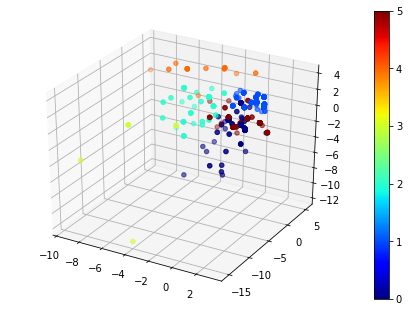

In [65]:
# plt.scatter(sparse_vec[:,0],sparse_vec[:,1],c=y_kmeans,cmap=plt.cm.Set1)
# plt.show()

scatter3d(sparse_vec[:,0], sparse_vec[:,1], sparse_vec[:,2], cs=y_kmeans)

In [83]:
import random
cluster_id = 0
print("# cluster {}:".format(cluster_id))
for i in range(len(y_dist[cluster_id])):
    if random.random()>0.9:
        p = y_dist[cluster_id][i]
        q = z_dist[cluster_id][i]
        if "statements" in q["body"].keys():
            print("id={}, file={}, size={}, label=".format(i,p,len(q["body"]["statements"])))
        else:
            print("id={}, file={}, size={}, label=".format(i,p,1))

# cluster 0:
id=2, file=Danku_demo.json, size=1, label=
id=22, file=EtHero.json, size=1, label=
id=40, file=EasyInvestUP.json, size=1, label=
id=44, file=PixelCons.json, size=1, label=
id=55, file=CryptoCupVirtualMatch.json, size=1, label=
id=68, file=RequestOMG.json, size=1, label=
id=73, file=EthColor.json, size=1, label=
id=74, file=EthColor.json, size=1, label=
id=78, file=UECToken.json, size=1, label=
id=89, file=AVToken.json, size=1, label=
id=103, file=AuctionityDepositEth.json, size=1, label=
id=109, file=XMIAsset.json, size=1, label=
id=119, file=SHA3_512.json, size=1, label=
id=127, file=Main.json, size=1, label=
id=128, file=ItemRegistry.json, size=1, label=
id=135, file=BinaryOptionV2.json, size=1, label=
id=140, file=XCPlugin.json, size=1, label=
id=146, file=BBLib.json, size=1, label=
id=164, file=TimeBankToken.json, size=1, label=
id=166, file=PresidentElections.json, size=1, label=
id=168, file=StarCards.json, size=1, label=
id=179, file=PlayerExchangeCore.json, size=1,

In [85]:
import pyperclip
pyperclip.copy(json.dumps(z_dist[cluster_id][188]))

In [84]:
import random
cluster_id = 0
print("# cluster {}:".format(cluster_id))
for i in range(len(y_dist[cluster_id])):
    p = y_dist[cluster_id][i]
    q = z_dist[cluster_id][i]
    if "statements" in q["body"].keys():
        print("id={}, file={}, size={}, label=".format(i,p,len(q["body"]["statements"])))
    else:
        print("id={}, file={}, size={}, label=".format(i,p,1))

# cluster 0:
id=0, file=Danku_demo.json, size=1, label=
id=1, file=Danku_demo.json, size=1, label=
id=2, file=Danku_demo.json, size=1, label=
id=3, file=Danku_demo.json, size=1, label=
id=4, file=AdvertisementFinance.json, size=1, label=
id=5, file=AdvertisementFinance.json, size=1, label=
id=6, file=AdvertisementFinance.json, size=1, label=
id=7, file=AdvertisementFinance.json, size=1, label=
id=8, file=HorseyToken.json, size=1, label=
id=9, file=BitminerFactoryToken.json, size=1, label=
id=10, file=EtherTool.json, size=1, label=
id=11, file=SecurityTokenRegistrar.json, size=1, label=
id=12, file=SecurityTokenRegistrar.json, size=1, label=
id=13, file=FactbarDeed.json, size=1, label=
id=14, file=LottoPI.json, size=1, label=
id=15, file=SpindleToken.json, size=1, label=
id=16, file=OlympusIndex.json, size=1, label=
id=17, file=fortunes.json, size=1, label=
id=18, file=NashvilleBeerToken.json, size=1, label=
id=19, file=BMBYToken.json, size=1, label=
id=20, file=Blend.json, size=1, labe

In [70]:
import random
cluster_id = 0
print("# cluster {}:".format(cluster_id))
for i in range(len(y_dist[cluster_id])):
    p = y_dist[cluster_id][i]
    q = z_dist[cluster_id][i]
    if "statements" in q["body"].keys():
        print("id={}, file={}, size={}, label=".format(i,p,len(q["body"]["statements"])))
    else:
        print("id={}, file={}, size={}, label=".format(i,p,1))

# cluster 0:
id=0, file=Danku_demo.json, size=1, label=
id=1, file=Danku_demo.json, size=1, label=
id=2, file=Danku_demo.json, size=1, label=
id=3, file=Danku_demo.json, size=1, label=
id=4, file=AdvertisementFinance.json, size=1, label=
id=5, file=AdvertisementFinance.json, size=1, label=
id=6, file=AdvertisementFinance.json, size=1, label=
id=7, file=AdvertisementFinance.json, size=1, label=
id=8, file=HorseyToken.json, size=1, label=
id=9, file=BitminerFactoryToken.json, size=1, label=
id=10, file=EtherTool.json, size=1, label=
id=11, file=SecurityTokenRegistrar.json, size=1, label=
id=12, file=SecurityTokenRegistrar.json, size=1, label=
id=13, file=FactbarDeed.json, size=1, label=
id=14, file=LottoPI.json, size=1, label=
id=15, file=SpindleToken.json, size=1, label=
id=16, file=fortunes.json, size=1, label=
id=17, file=NashvilleBeerToken.json, size=1, label=
id=18, file=BMBYToken.json, size=1, label=
id=19, file=Blend.json, size=1, label=
id=20, file=EtHero.json, size=1, label=
id=